# Merging and Data Analysis 

## Import the scraped data

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time
import pickle

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

#Read in df_list from the season_data/ folder

all_seasons = [2017,2018,2019,2020,2021]
df_list=[]

for year in all_seasons:
    temp_df = pd.read_csv('season_data/nba_spreads_{0}'.format(year)).drop('Unnamed: 0',inplace=False,axis=1) 
    df_list.append(temp_df)

## Merge all data

In [2]:
#Importing Raptor Data
raptor_df = pd.read_csv('input-data/aggregate-modern_RAPTOR_by_team.csv')
raptor_df = raptor_df.loc[raptor_df['season_type']=='RS'].reset_index(drop=True)

raptor_df = raptor_df.join(raptor_df.groupby(by = ['season','team'])['mp'].sum(),on=['season','team'],rsuffix='_team')
raptor_df['season_team_perc_mp'] = raptor_df['mp']/raptor_df['mp_team']
raptor_df['war_mp_weighted'] = raptor_df['season_team_perc_mp']*raptor_df['war_total']
raptor_df = raptor_df.join(raptor_df.groupby(by = ['season','team'])['war_mp_weighted'].sum(),on=['season','team'],rsuffix='_team')
team_value = raptor_df.groupby(by=['season','team'])['war_mp_weighted_team'].unique().str[0].reset_index()


#Merge the dataset with the RAPTOR data, then merge each season together
comb_df = pd.DataFrame()
for df_i in df_list:
    
    #Merging with RAPTOR data
    tv_merge = team_value.rename({'team':'Home_Team','war_mp_weighted_team':'Home_Team_value'},axis = 1,inplace=False,errors='raise')
    tv_merge['season'] = tv_merge['season'].astype(np.float64)

    ats_raptor_combined = pd.merge(df_i,tv_merge,how = 'left', on=['season','Home_Team'])

    tv_merge = tv_merge.rename({'Home_Team':'Away_Team','Home_Team_value':'Away_Team_value'},axis = 1,inplace=False,errors='raise')
    
    ats_raptor_combined = pd.merge(ats_raptor_combined,tv_merge,how = 'left', on=['season','Away_Team'])
    
    #Merge all seasons together.  Note that if this is the first loop, there are no seasons to merge together yet.
    if len(comb_df.index) == 0:
        comb_df = ats_raptor_combined
    else:
        comb_df = comb_df.append(ats_raptor_combined,ignore_index=True,verify_integrity=True)

combined_df = comb_df.copy()

In [3]:
#Do some additional differencing to get into the form we will use for regression
combined_df['goal_diff'] = combined_df['Home_Score']-combined_df['Away_Score']
combined_df['value_diff'] = combined_df['Home_Team_value'] - combined_df['Away_Team_value']
combined_df['last_n_ATS_diff'] = combined_df['Home_last_n_ATS'] - combined_df['Away_last_n_ATS']

#Create dummy variables for every Home and Away Team, and subtract them both to provide a home team factor
df_home = pd.get_dummies(combined_df['Home_Team'],dtype=np.float64)
df_away = pd.get_dummies(combined_df['Away_Team'],dtype=np.float64)
df_subtract = df_home-df_away

#Join together the dummy variables with the additional data
combined_w_dummy_df = combined_df.join(df_subtract)


## Regression Analysis

In [4]:
#Keep only the differenced values between home and away in our results
nba_df = combined_w_dummy_df.drop(['Date','Home_Score','Away_Score','Home_Team','Away_Team','Home_Spread','Away_Spread','Home_last_n_ATS','Away_last_n_ATS','Home_Team_value','Away_Team_value'],axis=1) 
nba_df.dropna(inplace=True)
#Create another categorical variable for season will be good

#First create test dataset 
X = nba_df.drop('goal_diff',axis=1)
y = nba_df['goal_diff']

#Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=113)

#Break up Training Data into 5 folds and save these indices
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
kf_indices = kf.split(X_train)

#First try a naive linear regression
lm = LinearRegression()
cv_1 = cross_val_score(lm,X_train,y_train,cv=kf_indices,scoring='r2')
print('Simple mean cv for naive LR r^2: {0:.3f}'.format(np.mean(cv_1))) 

#Now add a polynomial feature of degree 2 and use the same process
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
lm_poly = LinearRegression()
cv_2 = cross_val_score(estimator = lm_poly,X=X_train_poly,y=y_train,cv=kf.split(X_train_poly),scoring='r2')
print('Mean cv r^2 for all polynomials iterations: {0:.3f}'.format(np.mean(cv_2)))

#Add in a Ridge/LASSO regression to correct for overfitting from the high number of variables
#Ridge
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
ridge_model = RidgeCV(alphas = 10**np.linspace(-2,2,200),cv = kf.split(X_tr))
ridge_model.fit(X_tr,y_train)
print('r^2 from Ridge with cross validation: {0:.3f}'.format(ridge_model.score(X_tr,y_train)))

#LASSO
lasso_model = LassoCV(alphas=10**np.linspace(-2,2,200),cv=kf.split(X_tr))
lasso_model.fit(X_tr,y_train)
test_set_predictions = lasso_model.predict(X_tr)
print('r^2 from Lasso with cross validation: {0:.3f}'.format(lasso_model.score(X_tr,y_train)))

#Because our Ridge regression had the highest R^2 across all models, test it on the test data
std_te = StandardScaler()
std_te.fit(X_test.values)
X_te = std_te.transform(X_test.values)
ridge_test_pred = ridge_model.predict(X_te)
print('r^2 from Ridge with cross validation on the testing data: {0:.3f}'.format(r2_score(y_test, ridge_test_pred)))

Simple mean cv for naive LR r^2: 0.179
Mean cv r^2 for all polynomials iterations: 0.014
r^2 from Ridge with cross validation: 0.193
r^2 from Lasso with cross validation: 0.191
r^2 from Ridge with cross validation on the testing data: 0.137


In [5]:
#Break this up to look at different models for each season.  This may increase the predictive power, but we could potentially have issues if we do not have enough data.
list_of_seasons = [v for k,v in nba_df.groupby('season')]

In [6]:
#Looking at 2019
season_2019 = list_of_seasons[2].reset_index(drop=True)

#First create test dataset 
X = season_2019.drop('goal_diff',axis=1)
y = season_2019['goal_diff']

#Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=113)

#Break up Training Data into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
kf_indices = kf.split(X_train)

#First try a naive linear regression
lm = LinearRegression()
cv_1 = cross_val_score(lm,X_train,y_train,cv=kf_indices,scoring='r2')
print('Simple mean cv for naive LR r^2: {0:.3f}'.format(np.mean(cv_1)))

#Now add a polynomial feature of degree 2 and use the same process
poly_2019 = PolynomialFeatures(degree=2)
X_train_poly_2019 = poly_2019.fit_transform(X_train)
lm_poly_2019 = LinearRegression()
cv_2 = cross_val_score(estimator = lm_poly_2019,X=X_train_poly_2019,y=y_train,cv=kf.split(X_train_poly_2019),scoring='r2')
print('Mean cv r^2 for all polynomials iterations: {0:.3f}'.format(np.mean(cv_2)))

#Add in a Ridge regression for the naive regression and poly regression
std_2019 = StandardScaler()
std_2019.fit(X_train.values)
X_tr = std_2019.transform(X_train.values)
ridge_model_2019 = RidgeCV(alphas = 10**np.linspace(-2,2,200),cv = kf.split(X_tr))
ridge_model_2019.fit(X_tr,y_train)
print('r^2 from Ridge with cross validation: {0:.3f}'.format(ridge_model_2019.score(X_tr,y_train)))

#Add in a Lasso regression for the naive and poly regression
lasso_model = LassoCV(alphas=10**np.linspace(-2,2,200),cv=kf.split(X_tr))
lasso_model.fit(X_tr,y_train)
test_set_predictions = lasso_model.predict(X_tr)
print('r^2 from Lasso with cross validation: {0:.3f}'.format(lasso_model.score(X_tr,y_train)))

#Because our Ridge regression had the highest R^2 across all models, test it on the test data
std_2019_te = StandardScaler()
std_2019_te.fit(X_test.values)
X_te = std_2019_te.transform(X_test.values)
ridge_test_pred = ridge_model_2019.predict(X_te)
print('r^2 from Ridge with cross validation on the testing data: {0:.3f}'.format(r2_score(y_test, ridge_test_pred)))


Simple mean cv for naive LR r^2: 0.172
Mean cv r^2 for all polynomials iterations: -83497250141.412
r^2 from Ridge with cross validation: 0.222
r^2 from Lasso with cross validation: 0.200
r^2 from Ridge with cross validation on the testing data: 0.162


In [7]:
#Looking at 2021
season_2021 = list_of_seasons[4].drop('season',axis=1).reset_index(drop=True)

#First create test dataset 
X = season_2021.drop('goal_diff',axis=1)
y = season_2021['goal_diff']

#Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=113)

#Break up Training Data into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
kf_indices = kf.split(X_train)

#First try a naive linear regression
lm = LinearRegression()
cv_1 = cross_val_score(lm,X_train,y_train,cv=kf_indices,scoring='r2')
print('Simple mean cv for naive LR cv r^2: {0:.3f}'.format(np.mean(cv_1)))

#Now add a polynomial feature of degree 2 and use the same process
poly_2021 = PolynomialFeatures(degree=2)
X_train_poly_2021 = poly_2021.fit_transform(X_train)
lm_poly_2021 = LinearRegression()
cv_2 = cross_val_score(estimator = lm_poly_2021,X=X_train_poly_2021,y=y_train,cv=kf.split(X_train_poly_2021),scoring='r2')
print('Mean cv r^2 for all polynomials iterations: {0:.3f}'.format(np.mean(cv_2)))

#Add in a Ridge regression for the naive regression and poly regression
std_2021 = StandardScaler()
std_2021.fit(X_train.values)
X_tr = std_2021.transform(X_train.values)
ridge_model_2021 = RidgeCV(alphas = 10**np.linspace(-2,2,200),cv = kf.split(X_tr))
ridge_model_2021.fit(X_tr,y_train)
pred_train_ridge = ridge_model_2021.predict(X_tr)
ridge_r2 = r2_score(y_train,pred_train_ridge)
print('r^2 from Ridge with cross validation: {0:.3f}'.format(ridge_r2) )

#Because our Ridge regression had the highest R^2 across all models, test it on the test data
std_2021_te = StandardScaler()
std_2021_te.fit(X_test.values)
X_te = std_2021_te.transform(X_test.values)
ridge_test_pred = ridge_model_2021.predict(X_te)
print('r^2 from Ridge with cross validation on the testing data: {0:.3f}'.format(r2_score(y_test, ridge_test_pred)))

#The small testing R^2 is likely due to the small amount of data we have for 2021 so far.  We're over-fitting this model.
#We may be able to increase this R^2 in future models by imputing missing data rather than removing it.  It may also be wise to not use 5-fold cross-validation to get a more accurate model.

Simple mean cv for naive LR cv r^2: -0.116
Mean cv r^2 for all polynomials iterations: -173121016106077454336.000
r^2 from Ridge with cross validation: 0.288
r^2 from Ridge with cross validation on the testing data: -0.139


## Plots and Charts

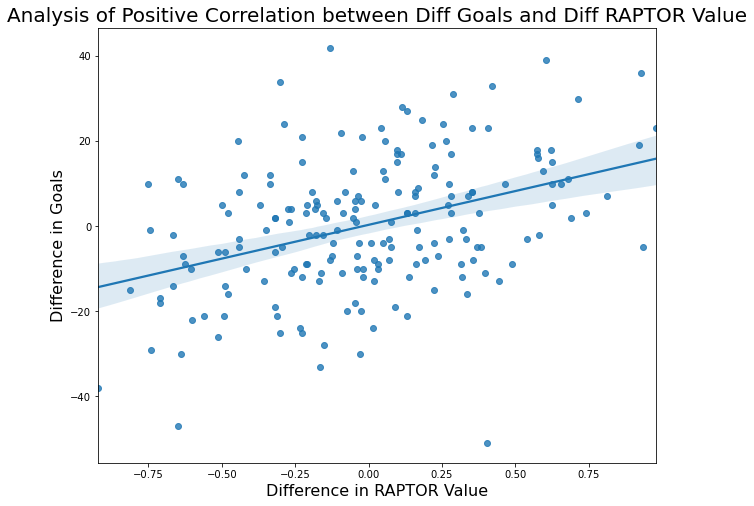

In [8]:
# Comparing difference of goals and difference between team RAPTOR Values for 2021

plt.figure(figsize = [10,8])
plt.title('Analysis of Positive Correlation between Diff Goals and Diff RAPTOR Value',fontsize = 20)
sns.regplot(data = season_2021, x='value_diff',y='goal_diff')
plt.xlabel('Difference in RAPTOR Value',fontsize = 16)
plt.ylabel('Difference in Goals',fontsize = 16);

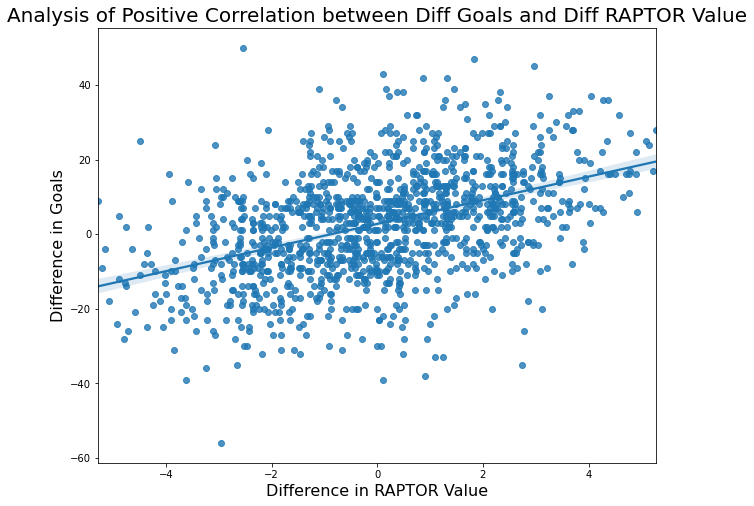

In [9]:
# Comparing difference of goals and difference between team RAPTOR Values for 2019

plt.figure(figsize = [10,8])
plt.title('Analysis of Positive Correlation between Diff Goals and Diff RAPTOR Value',fontsize = 20)
sns.regplot(data = season_2019, x='value_diff',y='goal_diff')
plt.xlabel('Difference in RAPTOR Value',fontsize = 16)
plt.ylabel('Difference in Goals',fontsize = 16);

In [10]:
#Creating a table of coefficients for 2021

pd.options.display.float_format = '{:.2f}'.format
coef_table = pd.DataFrame(zip(X_test.columns,ridge_model_2021.coef_),columns=['Feature','Coefficient'])
coef_table.head(32)

,Feature,Coefficient
0,value_diff,2.57
1,last_n_ATS_diff,-1.76
2,ATL,0.29
3,BOS,-0.25
4,BRK,0.30
5,CHA,0.22
6,CHI,-0.23
7,CLE,-0.28
8,DAL,-0.28
9,DEN,-0.09


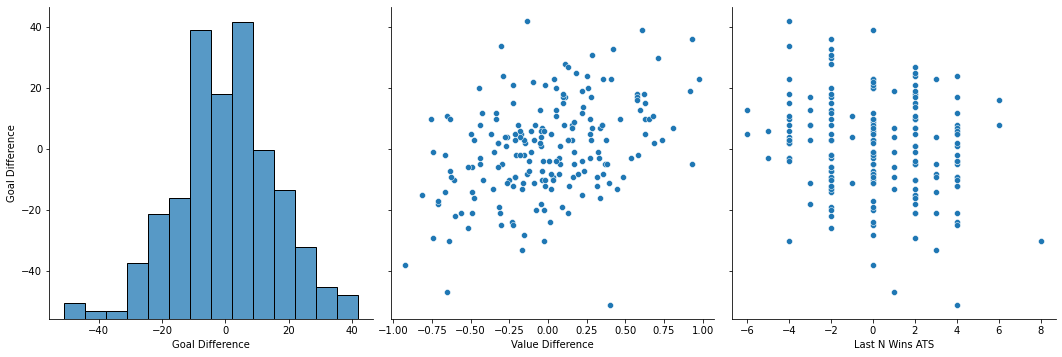

In [11]:
#Graph pair plot comparison between Goal Difference, Value Difference, and Last N Wins ATS
graphing_2021 = season_2021.rename({'goal_diff':'Goal Difference','value_diff':'Value Difference','last_n_ATS_diff':'Last N Wins ATS'},axis = 1)
sns.pairplot(data = graphing_2021,x_vars = ['Goal Difference','Value Difference','Last N Wins ATS'],y_vars = 'Goal Difference',height=5)

<Figure size 1080x720 with 0 Axes>

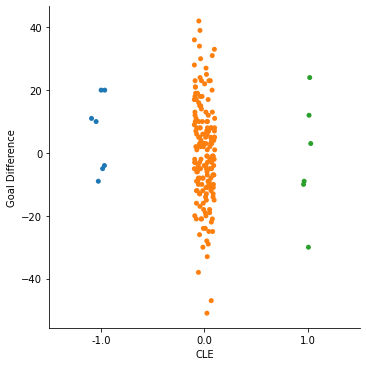

In [12]:
# Illustrating the possible values for the dummy variable of 'CLE' within 2021

graphing_2_rename =  season_2021.rename({'goal_diff':'Goal Difference'},axis=1)
plt.figure(figsize = [15,10])
sns.catplot(x="CLE", y="Goal Difference", data=graphing_2_rename)
plt.savefig("cle_indicator.png")